In [47]:
import math
import os
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import *

In [48]:
warnings.filterwarnings("ignore")

In [49]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [50]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        # seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [51]:
def predict_from_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = predictions.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    pred_org = scaler.inverse_transform(predictions)
    y_org = scaler.inverse_transform(y_test)

    print(math.sqrt(mean_squared_error(pred_org, y_org)))

    plt.plot(pred_org, label='Pred')
    plt.plot(y_org, label='Actual')
    plt.legend()
    plt.show()

## Univariate - Electricity

In [52]:
df = pd.read_csv('Electricity_Daily.csv')
df.set_index('Date', inplace=True)

In [53]:
split_index = int(len(df)*0.8)
train, test = df[:split_index], df[split_index:]

In [54]:
scalers = {}

for i in train.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
    scalers['scaler'+i] = scaler

for i in test.columns:
    scaler = scalers['scaler'+i]
    test[i] = scaler.fit_transform(test[i].values.reshape(-1,1))

In [55]:
n_steps = 360

X_train, y_train = split_sequence(train.values, n_steps)
X_test, y_test = split_sequence(test.values, n_steps)

n_features, n_seq, n_steps = X_train.shape[2], 12, 30

X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))

### ConvLSTM

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_3 (ConvLSTM2D)  (None, 1, 29, 64)         33536     
                                                                 
 flatten_4 (Flatten)         (None, 1856)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 1857      
                                                                 
Total params: 35,393
Trainable params: 35,393
Non-trainable params: 0
_________________________________________________________________


None
Epoch 1/30
97/97 [==============================] - 14s 94ms/step - loss: 0.0136 - root_mean_squared_error: 0.1168
Epoch 2/30
97/97 [==============================] - 10s 101ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725
Epoch 3/30
97/97 [==============================] - 12s 124ms/step - loss: 0.0039 - root_mean_squared_error: 0.0628
Epoch 4/30
97/97 [==============================] - 9s 92ms/step - loss: 0.0031 - root_mean_squared_error: 0.0557
Epoch 5/30
97/97 [==============================] - 12s 128ms/step - loss: 0.0027 - root_mean_squared_error: 0.0521
Epoch 6/30
97/97 [==============================] - 11s 114ms/step - loss: 0.0026 - root_mean_squared_error: 0.0505
Epoch 7/30
97/97 [==============================] - 14s 148ms/step - loss: 0.0025 - root_mean_squared_error: 0.0501
Epoch 8/30
97/97 [==============================] - 13s 132ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477
Epoch 9/30
97/97 [==============================] - 12s 126ms/step - l

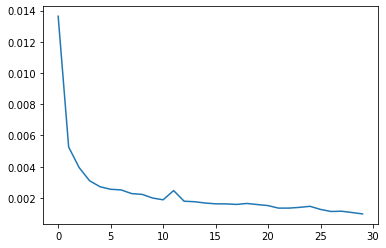

In [56]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq,1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))

print(model.summary())

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=30)
plt.plot(history.history['loss'])
plt.show()

16/16 [==============================] - 2s 38ms/step
120.54321225326987


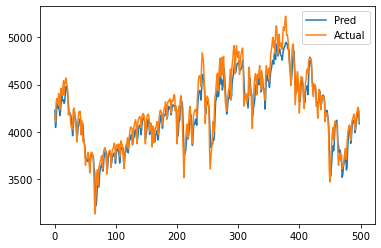

In [57]:
predict_from_model(model, X_test, y_test, scalers['scalerTotal'])

### CNN-LSTM

In [58]:
n_steps = 360

X_train, y_train = split_sequences(train.values, n_steps)
X_test, y_test = split_sequences(test.values, n_steps)

n_features, n_seq, n_steps = X_train.shape[2], 12, 30

X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_steps, n_features))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, None, 30, 64)     128       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 15, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, None, 960)        0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 50)                202200    
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                      

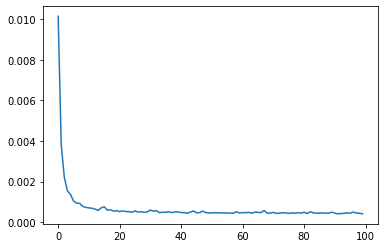

In [59]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),
input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

print(model.summary())

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=100)
plt.plot(history.history['loss'])
plt.show()

16/16 [==============================] - 3s 19ms/step
66.70369364984283


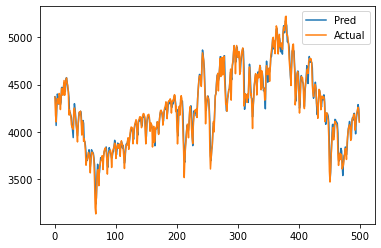

In [60]:
predict_from_model(model, X_test, y_test, scalers['scalerTotal'])

### Bidirectional LSTM

In [61]:
n_steps = 365

X_train, y_train = split_sequences(train.values, n_steps)
X_test, y_test = split_sequences(test.values, n_steps)

n_features = X_train.shape[2]

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100)              20800     
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
96/96 [==============================] - 77s 379ms/step - loss: 0.1679 - root_mean_squared_error: 0.4097
Epoch 2/100
96/96 [==============================] - 37s 388ms/step - loss: 0.0340 - root_mean_squared_error: 0.1845
Epoch 3/100
96/96 [==============================] - 39s 406ms/step - loss: 0.0042 - root_mean_squared_error: 0.0645
Epoch 4/100
96/96 [=====

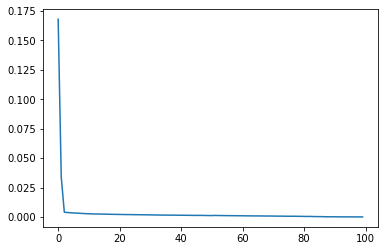

In [62]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))

print(model.summary())

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=100)
plt.plot(history.history['loss'])
plt.show()

16/16 [==============================] - 6s 133ms/step
31.08405908605196


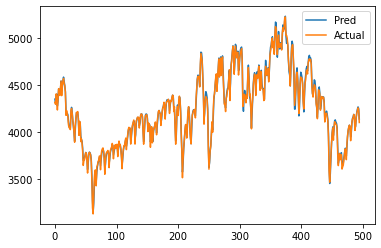

In [63]:
predict_from_model(model, X_test, y_test, scalers['scalerTotal'])

### LSTM

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 365, 64)           16896     
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
96/96 [==============================] - 96s 683ms/step - loss: 0.0207 - root_mean_squared_error: 0.1437
Epoch 2/50
96/96 [==============================] - 67s 696ms/step - loss: 0.0028 - root_mean_squared_error: 0.0527
Epoch 3/50
96/96 [==============================] - 67s 693ms/step - loss: 0.

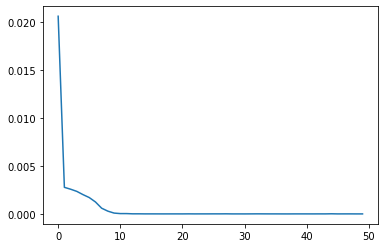

In [64]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(n_steps, n_features)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))

print(model.summary())

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=50)
plt.plot(history.history['loss'])
plt.show()

16/16 [==============================] - 5s 100ms/step
12.066963901099923


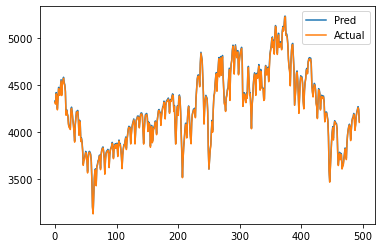

In [65]:
predict_from_model(model, X_test, y_test, scalers['scalerTotal'])